In [1]:
import os, sys
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr as corr

In [2]:
# context manager to suppress stdout
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

# Choose where to run

In [3]:
platform = 'paperspace' #@param ['colab', 'jupyter_notebook', 'paperspace'] {allow-input: true}

if platform == 'colab':
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=True)
    data_dir = '/content/drive/MyDrive/algonauts_2023_tutorial_data' #@param {type:"string"}
    submission_dir = '/content/drive/MyDrive/algonauts_2023_challenge_submission' #@param {type:"string"}

if platform == 'jupyter_notebook':
    data_dir = './data/algonauts_2023_challenge_data'
    submission_dir = './algonauts_2023_challenge_submission'

if platform == 'paperspace':
    data_dir = '/storage/algonauts_2023_challenge_data'
    submission_dir = './algonauts_2023_challenge_submission'

In [4]:
def visualize_correlation(lh_correlation, rh_correlation, data_dir):
    # Load the ROI classes mapping dictionaries
    roi_mapping_files = ['mapping_prf-visualrois.npy', 'mapping_floc-bodies.npy',
        'mapping_floc-faces.npy', 'mapping_floc-places.npy',
        'mapping_floc-words.npy', 'mapping_streams.npy']
    roi_name_maps = []
    for r in roi_mapping_files:
        roi_name_maps.append(np.load(os.path.join(data_dir, 'roi_masks', r),
            allow_pickle=True).item())

    # Load the ROI brain surface maps
    lh_challenge_roi_files = ['lh.prf-visualrois_challenge_space.npy',
        'lh.floc-bodies_challenge_space.npy', 'lh.floc-faces_challenge_space.npy',
        'lh.floc-places_challenge_space.npy', 'lh.floc-words_challenge_space.npy',
        'lh.streams_challenge_space.npy']
    rh_challenge_roi_files = ['rh.prf-visualrois_challenge_space.npy',
        'rh.floc-bodies_challenge_space.npy', 'rh.floc-faces_challenge_space.npy',
        'rh.floc-places_challenge_space.npy', 'rh.floc-words_challenge_space.npy',
        'rh.streams_challenge_space.npy']
    lh_challenge_rois = []
    rh_challenge_rois = []
    for r in range(len(lh_challenge_roi_files)):
        lh_challenge_rois.append(np.load(os.path.join(data_dir, 'roi_masks',
            lh_challenge_roi_files[r])))
        rh_challenge_rois.append(np.load(os.path.join(data_dir, 'roi_masks',
            rh_challenge_roi_files[r])))

    # Select the correlation results vertices of each ROI
    roi_names = []
    lh_roi_correlation = []
    rh_roi_correlation = []
    for r1 in range(len(lh_challenge_rois)):
        for r2 in roi_name_maps[r1].items():
            if r2[0] != 0: # zeros indicate to vertices falling outside the ROI of interest
                roi_names.append(r2[1])
                lh_roi_idx = np.where(lh_challenge_rois[r1] == r2[0])[0]
                rh_roi_idx = np.where(rh_challenge_rois[r1] == r2[0])[0]
                lh_roi_correlation.append(lh_correlation[lh_roi_idx])
                rh_roi_correlation.append(rh_correlation[rh_roi_idx])
    roi_names.append('All vertices')
    lh_roi_correlation.append(lh_correlation)
    rh_roi_correlation.append(rh_correlation)

    # Create the plot
    lh_median_roi_correlation = [np.median(lh_roi_correlation[r])
        for r in range(len(lh_roi_correlation))]
    rh_median_roi_correlation = [np.median(rh_roi_correlation[r])
        for r in range(len(rh_roi_correlation))]
    plt.figure(figsize=(18,6))
    x = np.arange(len(roi_names))
    width = 0.30
    plt.bar(x - width/2, lh_median_roi_correlation, width, label='Left Hemisphere')
    plt.bar(x + width/2, rh_median_roi_correlation, width,
        label='Right Hemishpere')
    plt.xlim(left=min(x)-.5, right=max(x)+.5)
    plt.ylim(bottom=0, top=1)
    plt.xlabel('ROIs')
    plt.xticks(ticks=x, labels=roi_names, rotation=60)
    plt.ylabel('Median Pearson\'s $r$')
    plt.legend(frameon=True, loc=1)

In [5]:
def calulate_correlaction(lh_fmri_val, lh_fmri_val_pred, rh_fmri_val, rh_fmri_val_pred):
    # Empty correlation array of shape: (LH vertices)
    lh_correlation = np.zeros(lh_fmri_val_pred.shape[1])
    # Correlate each predicted LH vertex with the corresponding ground truth vertex
    for v in range(lh_fmri_val_pred.shape[1]):
        lh_correlation[v] = corr(lh_fmri_val_pred[:,v], lh_fmri_val[:,v])[0]

    # Empty correlation array of shape: (RH vertices)
    rh_correlation = np.zeros(rh_fmri_val_pred.shape[1])
    # Correlate each predicted RH vertex with the corresponding ground truth vertex
    for v in range(rh_fmri_val_pred.shape[1]):
        rh_correlation[v] = corr(rh_fmri_val_pred[:,v], rh_fmri_val[:,v])[0]
    return lh_correlation, rh_correlation

In [6]:
def save_predictions(lh_fmri_test_pred, rh_fmri_test_pred, subject_submission_dir):
    lh_fmri_test_pred = lh_fmri_test_pred.astype(np.float32)
    rh_fmri_test_pred = rh_fmri_test_pred.astype(np.float32)

    np.save(os.path.join(subject_submission_dir, 'lh_pred_test.npy'), lh_fmri_test_pred)
    np.save(os.path.join(subject_submission_dir, 'rh_pred_test.npy'), rh_fmri_test_pred)

In [7]:
# Load fmri data and image datasets per subject
def load_FMRI_and_images(subj_dir, create_dataset_from_image_paths):
    train_img_dir  = os.path.join(subj_dir, 'training_split', 'training_images')
    test_img_dir  = os.path.join(subj_dir, 'test_split', 'test_images')
    train_img_list = os.listdir(train_img_dir)
    # Create a dataset
    batch_size = 300
    split = 0.9
    num_batches_train = int(len(train_img_list) * split // batch_size)
    num_samples_train = int(num_batches_train * batch_size)
    # Handle frmi files
    fmri_dir = os.path.join(subj_dir, 'training_split', 'training_fmri')
    lh_fmri = np.load(os.path.join(fmri_dir, 'lh_training_fmri.npy'))
    rh_fmri = np.load(os.path.join(fmri_dir, 'rh_training_fmri.npy'))

    print('LH training fMRI data shape:')
    print(lh_fmri.shape)
    print('(Training stimulus images × LH vertices)')

    print('\nRH training fMRI data shape:')
    print(rh_fmri.shape)
    print('(Training stimulus images × RH vertices)')
    lh_fmri_train = lh_fmri[:num_samples_train]
    lh_fmri_val = lh_fmri[num_samples_train:]
    rh_fmri_train = rh_fmri[:num_samples_train]
    rh_fmri_val = rh_fmri[num_samples_train:]

    dataset = create_dataset_from_image_paths(train_img_dir)
    # create train and validation dataset from the training dataset (90% train, 10% validation)
    train_dataset = dataset.take(num_batches_train)
    val_dataset = dataset.skip(num_batches_train)

    test_dataset = create_dataset_from_image_paths(test_img_dir)

    print('Training dataset size: ' + str(len(train_dataset)))
    print('Validation dataset size: ' + str(len(val_dataset)))
    print('Test dataset size: ' + str(len(test_dataset)) + '\n')

    return (train_dataset, val_dataset, test_dataset, lh_fmri_train, lh_fmri_val, rh_fmri_train, rh_fmri_val)

In [8]:
def run_pipeline(base_model, readout_layer, lh_fmri_train, rh_fmri_train, lh_fmri_val, rh_fmri_val, train_dataset, val_dataset, test_dataset):
    
    model = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer(readout_layer).output)
    
    features_list = []
    for batch in train_dataset:
        # Extract features
        batch_features = model.predict(batch)
        # Flatten the features
        flattened_features = batch_features.reshape(batch_features.shape[0], -1)
        # Append to list
        features_list.append(flattened_features)

    del model
    # Combine features from all batches
    features = np.vstack(features_list)
    print('Features shape:')
    print(features.shape)
    # Fit PCA to combined features
    pca = PCA(n_components=100)
    print('PCA fitting...')
    pca.fit(features)
    print('PCA over')

    # print('plot the explained variance')
    # plt.plot(pca.explained_variance_ratio_)
    # plt.show()
    # print('plot the cumulative explained variance')
    # plt.plot(np.cumsum(pca.explained_variance_ratio_))
    # plt.show()

    model = tf.keras.Model(inputs=base_model.input, outputs=base_model.get_layer(readout_layer).output)

    def extract_features(dataset, model, pca):
        features = []
        for batch in dataset:
            with HiddenPrints():
                ft = model.predict(batch)
                # Flatten the features
                ft = ft.reshape(ft.shape[0], -1)
                # Fit PCA to batch of features
                ft = pca.transform(ft)
            features.append(ft)
        return np.vstack(features)

    features_train = extract_features(train_dataset, model, pca)
    features_val = extract_features(val_dataset, model, pca)
    features_test = extract_features(test_dataset, model, pca)

    del model, pca
    # Fitting regression
    reg_lh = LinearRegression().fit(features_train, lh_fmri_train)
    reg_rh = LinearRegression().fit(features_train, rh_fmri_train)
    # Use fitted linear regressions to predict the validation and test fMRI data
    lh_fmri_val_pred = reg_lh.predict(features_val)
    lh_fmri_test_pred = reg_lh.predict(features_test)
    rh_fmri_val_pred = reg_rh.predict(features_val)
    rh_fmri_test_pred = reg_rh.predict(features_test)
    # Calculate correlation
    lh_correlation, rh_correlation = calulate_correlaction(lh_fmri_val, lh_fmri_val_pred, rh_fmri_val, rh_fmri_val_pred)
    return (lh_fmri_test_pred, rh_fmri_test_pred, lh_correlation, rh_correlation)

# Specify image preprocessing steps, model and layers

In [12]:
def create_dataset_from_image_paths(image_dir):
    dataset = tf.keras.utils.image_dataset_from_directory(image_dir, image_size=(300, 300), labels=None, shuffle=False, batch_size=300)
    dataset = dataset.map(tf.keras.applications.efficientnet.preprocess_input)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Take models from here https://keras.io/api/applications/
base_model = tf.keras.applications.EfficientNetB3(weights='imagenet')
print(*(layer.name for layer in base_model.layers), sep=' -> ')

layers = ['block6f_activation', 'block6f_se_squeeze', 'block6f_se_reshape', 'block6f_se_reduce', 'block6f_se_expand', 'block6f_se_excite', 'block6f_project_conv', 'block6f_project_bn', 'block6f_drop', 'block6f_add']

input_2 -> rescaling_1 -> normalization_1 -> tf.math.truediv_1 -> stem_conv_pad -> stem_conv -> stem_bn -> stem_activation -> block1a_dwconv -> block1a_bn -> block1a_activation -> block1a_se_squeeze -> block1a_se_reshape -> block1a_se_reduce -> block1a_se_expand -> block1a_se_excite -> block1a_project_conv -> block1a_project_bn -> block1b_dwconv -> block1b_bn -> block1b_activation -> block1b_se_squeeze -> block1b_se_reshape -> block1b_se_reduce -> block1b_se_expand -> block1b_se_excite -> block1b_project_conv -> block1b_project_bn -> block1b_drop -> block1b_add -> block2a_expand_conv -> block2a_expand_bn -> block2a_expand_activation -> block2a_dwconv_pad -> block2a_dwconv -> block2a_bn -> block2a_activation -> block2a_se_squeeze -> block2a_se_reshape -> block2a_se_reduce -> block2a_se_expand -> block2a_se_excite -> block2a_project_conv -> block2a_project_bn -> block2b_expand_conv -> block2b_expand_bn -> block2b_expand_activation -> block2b_dwconv -> block2b_bn -> block2b_activation -> 

# Specify subject

In [10]:
subj = 'subj01'
subj_data_dir = os.path.join(data_dir, subj)
subj_submission_dir = os.path.join(submission_dir, subj)
train_dataset, val_dataset, test_dataset, lh_fmri_train, lh_fmri_val, rh_fmri_train, rh_fmri_val = load_FMRI_and_images(subj_data_dir, create_dataset_from_image_paths)

LH training fMRI data shape:
(9841, 19004)
(Training stimulus images × LH vertices)

RH training fMRI data shape:
(9841, 20544)
(Training stimulus images × RH vertices)
Found 9841 files belonging to 1 classes.
Found 159 files belonging to 1 classes.
Training dataset size: 29
Validation dataset size: 4
Test dataset size: 1



# Run the pipeline

Readout layer: block6f_activation

10/10 [==============================] - 2s 156ms/step
Features shape:
(8700, 139200)
PCA fitting...
PCA over
Left hemisphere median correlation:  0.42595274098564784
Right hemisphere median correlation:  0.43353597376872016


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Readout layer: block6f_se_squeeze

10/10 [==============================] - 2s 159ms/step
Features shape:
(8700, 1392)
PCA fitting...
PCA over
Left hemisphere median correlation:  0.3738220160390161
Right hemisphere median correlation:  0.3832225711692102


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Readout layer: block6f_se_reshape

10/10 [==============================] - 2s 157ms/step
Features shape:
(8700, 1392)
PCA fitting...
PCA over
Left hemisphere median correlation:  0.3748290090066704
Right hemisphere median correlation:  0.383608826174097


/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Readout layer: block6f_se_reduce

10/10 [==============================] - 2s 158ms/step
Features shape:
(8700, 58)
PCA fitting...


ValueError: n_components=100 must be between 0 and min(n_samples, n_features)=58 with svd_solver='full'

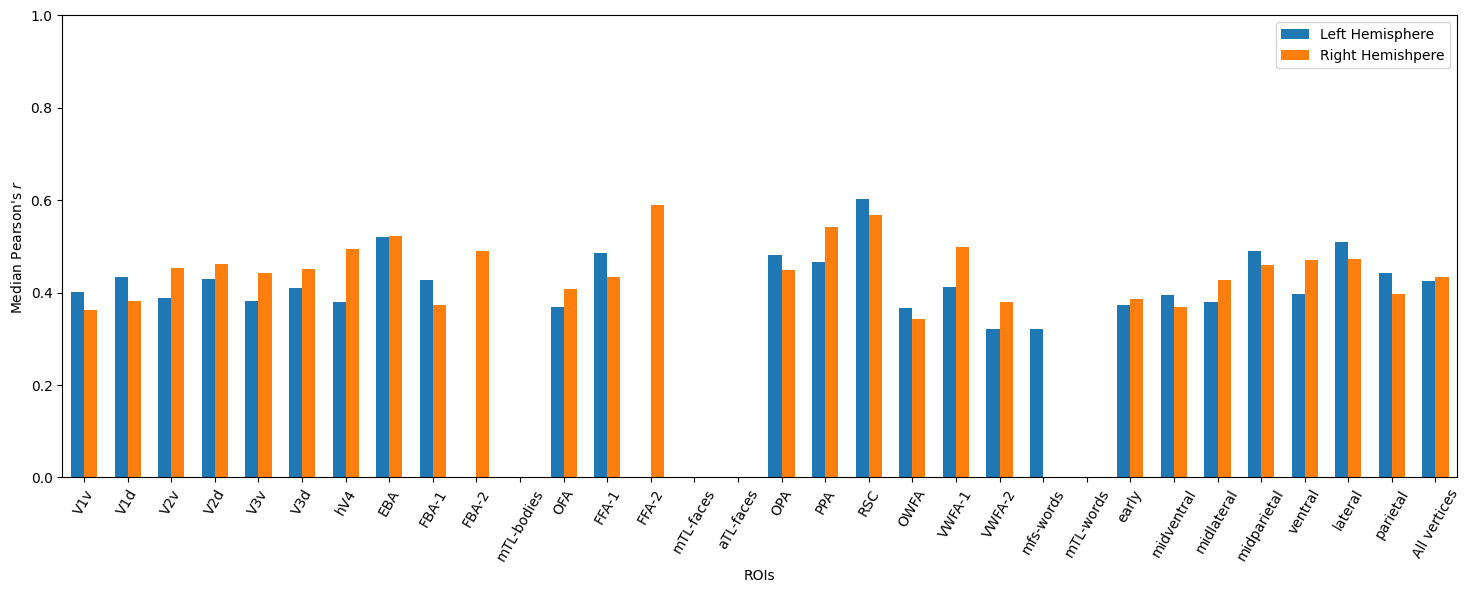

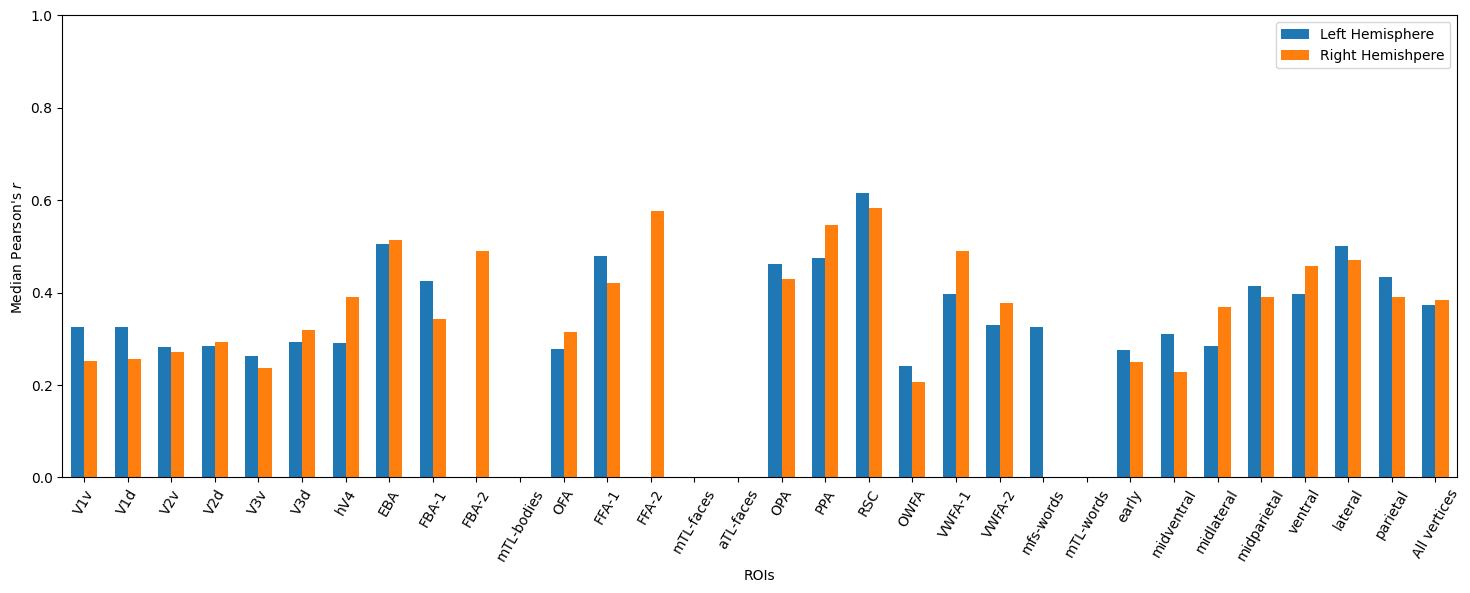

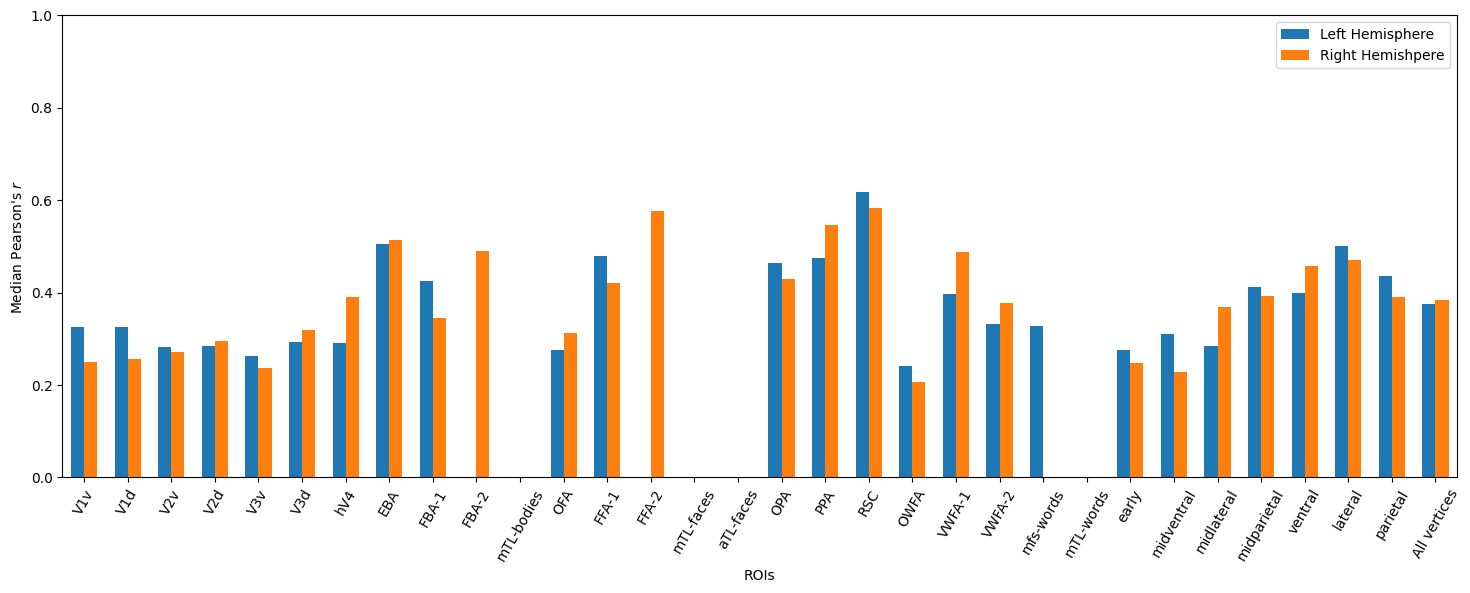

In [13]:
for readout_layer in layers:
    print(f'Readout layer: {readout_layer}\n')
    lh_fmri_test_pred, rh_fmri_test_pred, lh_correlation, rh_correlation = run_pipeline(
        base_model, readout_layer, 
        lh_fmri_train, rh_fmri_train, lh_fmri_val, rh_fmri_val, 
        train_dataset, val_dataset, test_dataset
    )
    print('Left hemisphere median correlation: ', np.median(lh_correlation))
    print('Right hemisphere median correlation: ', np.median(rh_correlation))
    file_path = os.path.join(subj_submission_dir, 'correlations.txt')
    if os.path.exists(file_path):
        with open(file_path,'a') as f:
            f.write(f'{readout_layer} {np.median(lh_correlation)} {np.median(rh_correlation)}\n')
    else:
        with open(file_path,'w') as f:
            f.write(f'{readout_layer} {np.median(lh_correlation)} {np.median(rh_correlation)}\n')
    visualize_correlation(lh_correlation, rh_correlation, subj_data_dir)
    save_predictions(lh_fmri_test_pred, rh_fmri_test_pred, subj_submission_dir)